In [1]:
%%capture
from tqdm import tqdm
from convokit import Corpus, Speaker, Utterance
from collections import defaultdict
import pandas as pd
import pprint as pp
from IPython.display import display
from modules.DataPreprocesser import DataPreprocesser
from modules import CorpusUtils as corp
import torch

# Add the src directory to the path
import sys
import os

# Add the src
sys.path.append(os.path.abspath("."))
import import_ipynb

#Convokit Imports
from convokit.forecaster.CRAFTModel import CRAFTModel
from convokit.forecaster.forecaster import Forecaster

# Creating KODIS Corpus Object

### Create Corpus

In [2]:
filepath = "/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/data/preprocessed_dyads.csv"
final_data = DataPreprocesser(filepath)
test_corp= corp.corpusBuilder(final_data)

/Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/src/modules/DataPreprocesser.py:111: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1702723625' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.utterancesDF.loc[13988, 'timestamp']= '1702723625'


2107


27498it [00:00, 56260.50it/s]


In [3]:
test_corp.print_summary_stats()

Number of Speakers: 4214
Number of Utterances: 27498
Number of Conversations: 2107


### Add conversation lengths as conversation metadata
- 1 is "impasse"
- 0 is "success"

In [4]:
for convo in test_corp.iter_conversations():
    convo_len = len(convo.get_utterance_ids())  # Count utterances in the conversation
    convo.add_meta("convo_len", convo_len)      # Store as conversation-level metadata
    some_convo = test_corp.get_conversation("utt0_con0")
print("Length of conversation:", some_convo.retrieve_meta("convo_len"))

Length of conversation: 14


### Add Conversation Labels from Final Pre-processed Dataframe as conversation metadata

In [5]:
for idx, row in final_data.getDataframe().iterrows():
    convo_id = f"utt0_con{idx}"  # generate conversation_id format from index
    label = row["dispute_outcome"]  # update if your label column is named differently
    if convo_id in test_corp.conversations:
        test_corp.get_conversation(convo_id).meta["label"] = label

# Creating Forecaster and Model Objects

### CMV Model and Forecaster Object

In [6]:
model2 = CRAFTModel(
    initial_weights= "craft-cmv-finetuned",  # or "craft-wiki-finetuned"
    torch_device="cuda" if torch.cuda.is_available() else "cpu"
)

In [7]:
# Use 'label' because we added it to conversation.meta["label"]
forecaster2 = Forecaster(
    forecaster_model=model2,
    labeler="label",  # uses conversation.meta["label"]
    forecast_attribute_name="prediction",
    forecast_prob_attribute_name="pred_score"
)

### Wiki Model and Forecaster Object

In [8]:
model = CRAFTModel(
    initial_weights= "craft-wiki-finetuned",  # or "craft-wiki-finetuned"
    torch_device="cuda" if torch.cuda.is_available() else "cpu"
)

In [9]:
# Use 'label' because we added it to conversation.meta["label"]
forecaster = Forecaster(
    forecaster_model=model,
    labeler="label",  # uses conversation.meta["label"]
    forecast_attribute_name="prediction",
    forecast_prob_attribute_name="pred_score"
)

# Model Weight Info

### **craft‑wiki‑pretrained**

- Contains only the utterance and context encoder layers pre‑trained on the CGA‑Wikipedia data (via next‑comment prediction), but its classifier head (the SingleTargetClf) is still at its random initialization.

- Intended as a starting point if you want to fine‑tune CRAFT on your own conversational data (you’ll call fit to learn the classifier weights).

### **craft‑wiki‑finetuned**
- Builds on the above by having already fine‑tuned the entire network (including the classifier head).
- Ready for inference only—you can call transform immediately and get sensible forecasts without any further training.

# Run predictions on fine-tuned WIKI dataset with CRAFT model

### Fresh Kodis Corpus

In [10]:
test_corp= corp.corpusBuilder(final_data)
for idx, row in final_data.getDataframe().iterrows():
    convo_id = f"utt0_con{idx}"  # generate conversation_id format from index
    label = row["dispute_outcome"]  # update if your label column is named differently
    if convo_id in test_corp.conversations:
        test_corp.get_conversation(convo_id).meta["label"] = label

27498it [00:01, 23682.26it/s]


### Make predictions as conversation evolves (temporally) - When will this conversation derail?

In [ ]:
test_corp = forecaster.transform(test_corp)

Accuracy     0.450403
Precision    0.233220
Recall       0.927224
FPR          0.651498
F1           0.372698
dtype: float64


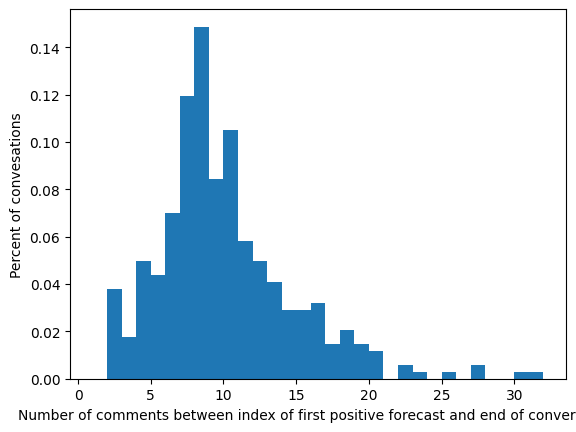

Horizon statistics (# of comments between first positive forecast and conversation end):
Mean = 9.723837209302326, Median = 9.0


(                 label     score  forecast
 conversation_id                           
 utt0_con0            0  0.481174       0.0
 utt0_con1            0  0.785086       1.0
 utt0_con2            0  0.540673       0.0
 utt0_con3            0  0.376359       0.0
 utt0_con4            0  0.868184       1.0
 ...                ...       ...       ...
 utt0_con2102         0  0.677453       1.0
 utt0_con2103         1  0.954360       1.0
 utt0_con2104         0  0.645120       1.0
 utt0_con2105         0  0.737709       1.0
 utt0_con2106         0  0.264288       0.0
 
 [2107 rows x 3 columns],
 {'Accuracy': np.float64(0.4504034171808258),
  'Precision': np.float64(0.23322033898305083),
  'Recall': np.float64(0.9272237196765498),
  'FPR': np.float64(0.6514976958525346),
  'F1': np.float64(0.37269772481040087)})

In [12]:
forecaster.summarize(test_corp)

### Make predictions on last utterance only (classification) - Is this a derailed conversation?

In [13]:
test_corp2= corp.corpusBuilder(final_data)
for idx, row in final_data.getDataframe().iterrows():
    convo_id = f"utt0_con{idx}"  # generate conversation_id format from index
    label = row["dispute_outcome"]  # update if your label column is named differently
    if convo_id in test_corp2.conversations:
        test_corp2.get_conversation(convo_id).meta["label"] = label

27498it [00:00, 70236.09it/s]


In [ ]:
def last_utterance_selector(context_tuple):
    all_utts = context_tuple.current_utterance.get_conversation().get_chronological_utterance_list()
    return context_tuple.current_utterance.id == all_utts[-1].id

test_corp_classification = forecaster.transform(test_corp2, last_utterance_selector)

Accuracy     0.831989
Precision    0.517454
Recall       0.679245
FPR          0.135369
F1           0.587413
dtype: float64


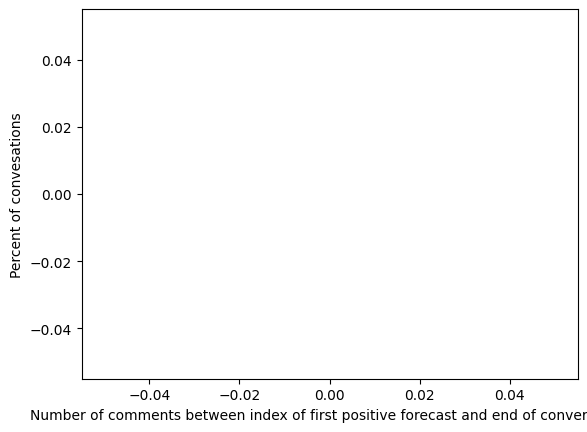

Horizon statistics (# of comments between first positive forecast and conversation end):
Mean = 1.0, Median = 1.0


In [15]:
convo_df, metrics = forecaster.summarize(test_corp2)

# Run predictions on fine-tuned REDDIT CMV dataset with CRAFT model

### Fresh Kodis Corpus

In [16]:
test_corp3= corp.corpusBuilder(final_data)
for idx, row in final_data.getDataframe().iterrows():
    convo_id = f"utt0_con{idx}"  # generate conversation_id format from index
    label = row["dispute_outcome"]  # update if your label column is named differently
    if convo_id in test_corp3.conversations:
        test_corp3.get_conversation(convo_id).meta["label"] = label


27498it [00:00, 40008.33it/s]


### Make predictions as conversation evolves (temporally) - When will this conversation derail?

In [ ]:
test_corp3 = forecaster2.transform(test_corp3)

Accuracy     0.240152
Precision    0.174603
Recall       0.889488
FPR          0.898618
F1           0.291906
dtype: float64


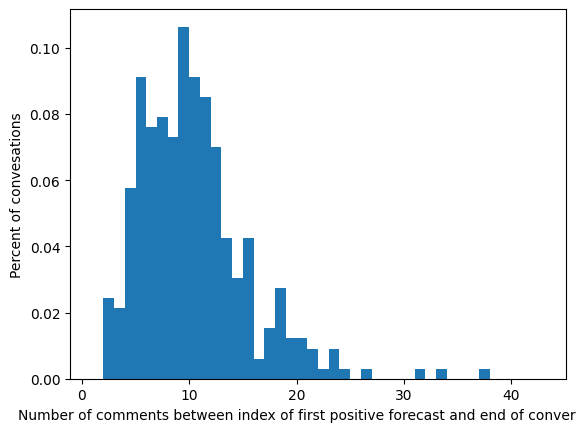

Horizon statistics (# of comments between first positive forecast and conversation end):
Mean = 10.006060606060606, Median = 9.0


In [18]:
convo_df, metrics = forecaster2.summarize(test_corp3)

### Make predictions on last utterance only (classification) - Is this a derailed conversation?


In [19]:
test_corp5= corp.corpusBuilder(final_data)
for idx, row in final_data.getDataframe().iterrows():
    convo_id = f"utt0_con{idx}"  # generate conversation_id format from index
    label = row["dispute_outcome"]  # update if your label column is named differently
    if convo_id in test_corp5.conversations:
        test_corp5.get_conversation(convo_id).meta["label"] = label

27498it [00:00, 70695.85it/s]


In [ ]:
def last_utterance_selector(context_tuple):
    all_utts = context_tuple.current_utterance.get_conversation().get_chronological_utterance_list()
    return context_tuple.current_utterance.id == all_utts[-1].id

test_corp_classification = forecaster.transform(test_corp5, last_utterance_selector)

Accuracy     0.831989
Precision    0.517454
Recall       0.679245
FPR          0.135369
F1           0.587413
dtype: float64


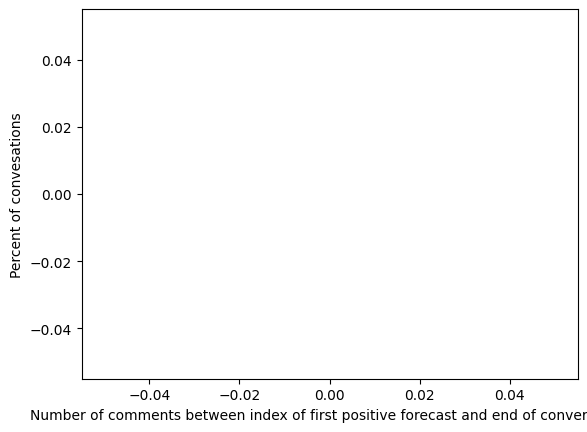

Horizon statistics (# of comments between first positive forecast and conversation end):
Mean = 1.0, Median = 1.0


(                 label     score  forecast
 conversation_id                           
 utt0_con0            0  0.374480       0.0
 utt0_con1            0  0.673291       1.0
 utt0_con2            0  0.407664       0.0
 utt0_con3            0  0.188250       0.0
 utt0_con4            0  0.166284       0.0
 ...                ...       ...       ...
 utt0_con2102         0  0.326548       0.0
 utt0_con2103         1  0.762463       1.0
 utt0_con2104         0  0.463558       0.0
 utt0_con2105         0  0.270675       0.0
 utt0_con2106         0  0.088958       0.0
 
 [2107 rows x 3 columns],
 {'Accuracy': np.float64(0.8319886093972473),
  'Precision': np.float64(0.5174537987679672),
  'Recall': np.float64(0.6792452830188679),
  'FPR': np.float64(0.13536866359447006),
  'F1': np.float64(0.5874125874125874)})

In [21]:
forecaster2.summarize(test_corp_classification)

# Run predictions on test sets for CMV and WIKI datasets using respecitve fine-tuned CRAFT Models (todo)

# Comparing fine-tuned Models on KODIS Corpus

### Running predictions on both fine-tuned wiki and cmv CRAFT models temporally on all utterances

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from convokit import Corpus, Forecaster, CRAFTModel
from modules.DataPreprocesser import DataPreprocesser  # adjust imports to your project structure
from modules import CorpusUtils as corp


# corpusBuilder should return a ConvoKit Corpus
corp1 = corp.corpusBuilder(final_data)
corp2 = corp.corpusBuilder(final_data)

# Assign conversation-level labels
for idx, row in final_data.getDataframe().iterrows():
    convo_id = f"utt0_con{idx}"
    label = row["dispute_outcome"]
    if convo_id in corp1.conversations:
        corp1.get_conversation(convo_id).meta["label"] = label
    if convo_id in corp2.conversations:
        corp2.get_conversation(convo_id).meta["label"] = label

# 2. Initialize two forecasters with different CRAFT weights
device = "cuda" if torch.cuda.is_available() else "cpu"
craft_wiki = CRAFTModel("craft-wiki-finetuned", torch_device=device)
craft_cmv  = CRAFTModel("craft-cmv-finetuned",  torch_device=device)
forecaster1 = Forecaster(craft_wiki, "label")
forecaster2 = Forecaster(craft_cmv,  "label")

# 3. Helper to apply transform and return utterance-level DataFrame

def get_forecast_df(forecaster, corpus, selector=lambda ctx: True):
    # Annotate the corpus
    annotated = forecaster.transform(corpus, selector)
    # Extract utterance-level DataFrame
    return annotated

# 4. Transform both corpora
corp1 = get_forecast_df(forecaster1, corp1)
corp2 = get_forecast_df(forecaster2, corp2)


### Getting average derailement prediction and frequency of forecast probabilities across all utterances

Summary statistics for forecast probabilities:
           mean_prob  std_prob  median_prob
corp-wiki   0.440724  0.267856     0.381885
corp-cmv    0.541044  0.271951     0.528305


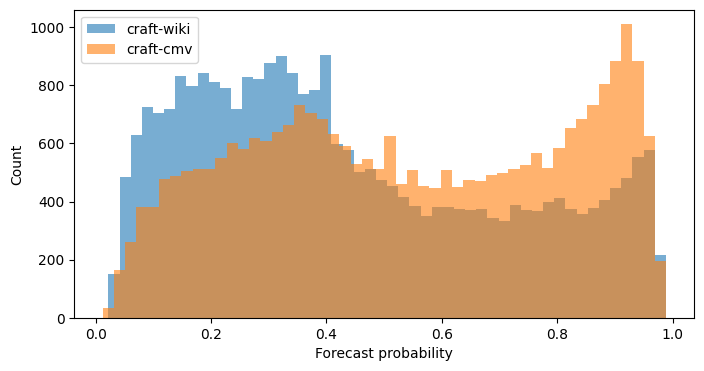

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

# 1) extract the utterance‑level DataFrames from the two corpora
utt_df1 = corp1.get_utterances_dataframe()
utt_df2 = corp2.get_utterances_dataframe()


# 5. Keep only the forecast columns and drop NA
forecast_df1 = utt_df1[['meta.forecast', 'meta.forecast_prob']].dropna()
forecast_df2 = utt_df2[['meta.forecast', 'meta.forecast_prob']].dropna()

# 6. Summary statistics
summary = pd.DataFrame({
    'mean_prob':  [forecast_df1['meta.forecast_prob'].mean(),  forecast_df2['meta.forecast_prob'].mean()],
    'std_prob':   [forecast_df1['meta.forecast_prob'].std(),   forecast_df2['meta.forecast_prob'].std()],
    'median_prob':[forecast_df1['meta.forecast_prob'].median(),forecast_df2['meta.forecast_prob'].median()],
}, index=['corp-wiki', 'corp-cmv'])
print("Summary statistics for forecast probabilities:")
print(summary)

# 7. Plot histograms
plt.figure(figsize=(8,4))
plt.hist(forecast_df1['meta.forecast_prob'], bins=50, alpha=0.6, label='craft-wiki')
plt.hist(forecast_df2['meta.forecast_prob'], bins=50, alpha=0.6, label='craft-cmv')
plt.xlabel('Forecast probability')
plt.ylabel('Count')
plt.legend()
plt.show()


### Conversation-level AUC and PR Curves
to create these plots, I looked at [Forecasters](https://github.com/CornellNLP/ConvoKit/blob/master/convokit/forecaster/forecaster.py#L139) code for aggregating utternce-levele metrics on a conversation level where:
- np.max(forecast_scores) is highest probability the model ever assigned to this conversation
- np.max(forecasts) is if the model ever cross its decision threshold and predict 1 (derailement) for thsi conversation
### Insights
- baseline positive class rate (successful dispute) for KODIS is 17.6%.
- PR curve bottoms out at baseline accuracy wuth higher decision thresholds, so no presicion-accuracy trade-off. Essesntially, lower decision threshold -> model is as good as baseline posititve rate, so never predicts derailment. Probably due to high impassee/success class imbalance
- AUC still looks high for both bc of the class imbalance for derailement disputes I think

meta.label
0    1736
1     371
Name: count, dtype: int64

Positive class rate: 17.61%
Baseline accuracy (derailement): 0.176


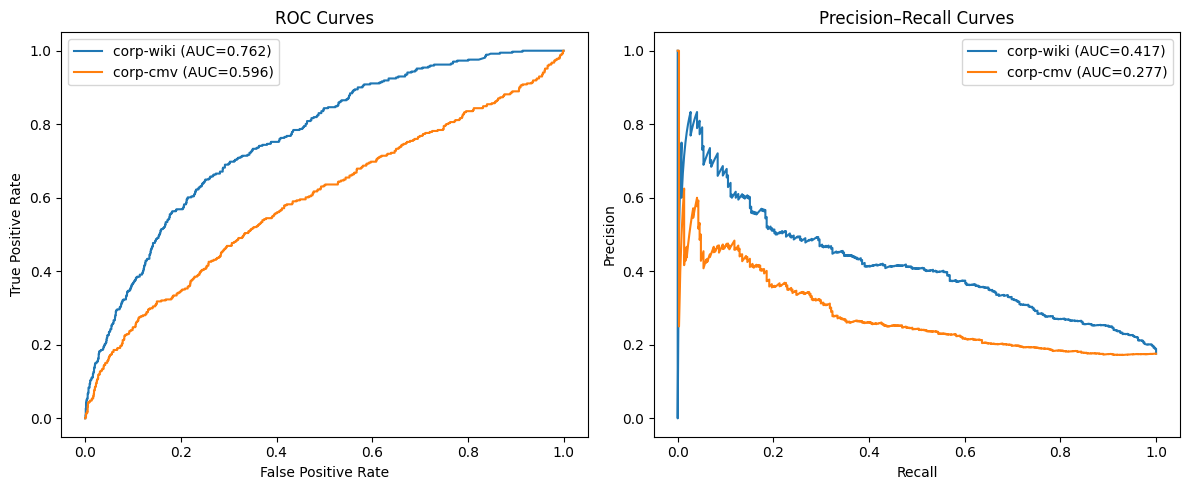

In [66]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import numpy as np

def get_conv_level_scores(corpus):
    # 1) grab all utterances with a forecast
    utt = (corpus
            .get_utterances_dataframe()[['conversation_id','meta.forecast_prob']]
            .dropna())
    conv_scores = utt.groupby('conversation_id')['meta.forecast_prob'].max()
    conv_df = corpus.get_conversations_dataframe()
    conv_scores = conv_scores.reindex(conv_df.index, fill_value=0)
    y_true = conv_df['meta.label'].astype(int)
    y_scores = conv_scores.values
    return y_true, y_scores

def print_baseline_accuracy(corpus, label_field="label"):
    # pull out the conversation‑level labels
    conv_df = corpus.get_conversations_dataframe()[[f"meta.{label_field}"]]
    
    # count each class
    counts = conv_df["meta.label"].value_counts()
    min_label = counts.idxmin()    
    min_count = counts.min()      
    total     = counts.sum()
    baseline_acc = min_count / total
    print(f"Baseline accuracy (derailement): {baseline_acc:.3f}")
    


conv_df = corp1.get_conversations_dataframe()[[f"meta.label"]]
display(conv_df["meta.label"].value_counts())
y1, s1 = get_conv_level_scores(corp1)
y2, s2 = get_conv_level_scores(corp2)

positive_rate = np.mean(y1)
print(f"Positive class rate: {positive_rate:.2%}")
print_baseline_accuracy(corp1)

# compute ROC and PR metrics
fpr1, tpr1, _    = roc_curve(y1, s1)
roc_auc1         = auc(fpr1, tpr1)
fpr2, tpr2, _    = roc_curve(y2, s2)
roc_auc2         = auc(fpr2, tpr2)

prec1, rec1, _   = precision_recall_curve(y1, s1)
pr_auc1          = auc(rec1, prec1)
prec2, rec2, _   = precision_recall_curve(y2, s2)
pr_auc2          = auc(rec2, prec2)

# plot side‑by‑side
fig, (ax_roc, ax_pr) = plt.subplots(1, 2, figsize=(12,5))

# ROC panel
ax_roc.plot(fpr1, tpr1, label=f'corp-wiki (AUC={roc_auc1:.3f})')
ax_roc.plot(fpr2, tpr2, label=f'corp-cmv (AUC={roc_auc2:.3f})')
ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.set_title('ROC Curves')
ax_roc.legend()

# PR panel
ax_pr.plot(rec1, prec1, label=f'corp-wiki (AUC={pr_auc1:.3f})')
ax_pr.plot(rec2, prec2, label=f'corp-cmv (AUC={pr_auc2:.3f})')
ax_pr.set_xlabel('Recall')
ax_pr.set_ylabel('Precision')
ax_pr.set_title('Precision–Recall Curves')
ax_pr.legend()

plt.tight_layout()
plt.show()

### Comparing forcaster summaries for both fine-tuned wiki and cmv CRAFT models predictions
- Ran using Forecasers summarize function
### Insights
- since our dataset has an average length of 13.5 utterances, the forecast horizon on average is 9.72 and 10 respecitvely for the WIKI and cmv models, meaning derailement is forecats towards the end of a dispute
- on a conversation-level, accuracy of predicting derailement is pretty low and F1 scores are low

Average conversation length in pre-process KODIS: 13.05 utterances
Stats for fine-tuned wiki model predicitons 
 -------------------
Accuracy     0.450403
Precision    0.233220
Recall       0.927224
FPR          0.651498
F1           0.372698
dtype: float64


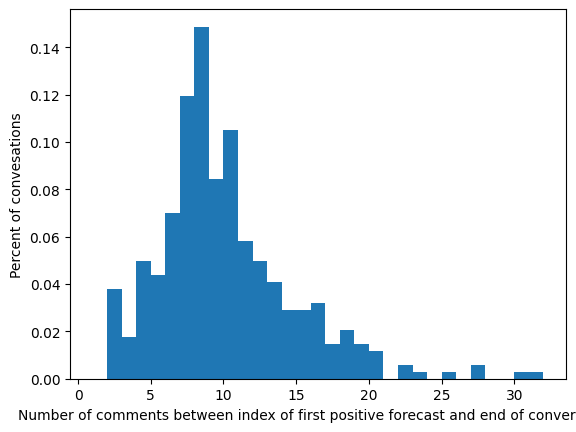

Horizon statistics (# of comments between first positive forecast and conversation end):
Mean = 9.723837209302326, Median = 9.0


Stats for fine-tuned cmv model predicitons  
 -------------------
Accuracy     0.240152
Precision    0.174603
Recall       0.889488
FPR          0.898618
F1           0.291906
dtype: float64


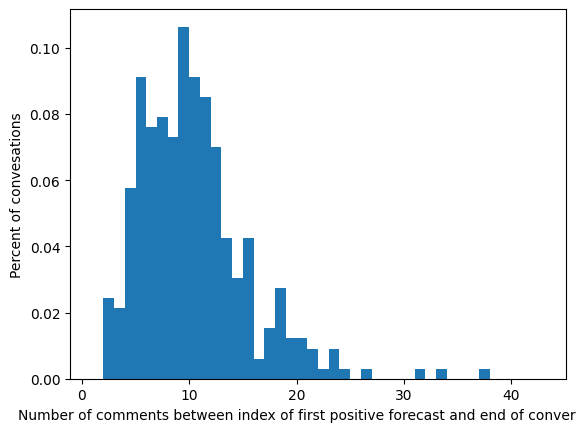

Horizon statistics (# of comments between first positive forecast and conversation end):
Mean = 10.006060606060606, Median = 9.0
=== Overall metrics ===


,Accuracy,Precision,Recall,FPR,F1
corp1,0.450403,0.233220,0.927224,0.651498,0.372698
corp2,0.240152,0.174603,0.889488,0.898618,0.291906


=== Conversation‑level forecasts comparison ===


,label,score1,forecast1,score2,forecast2
conversation_id,,,,,
utt0_con0,0,0.481174,0.0,0.912546,1.0
utt0_con1,0,0.785086,1.0,0.798515,1.0
utt0_con2,0,0.540673,0.0,0.734454,1.0
utt0_con3,0,0.376359,0.0,0.881353,1.0
utt0_con4,0,0.868184,1.0,0.775170,1.0
...,...,...,...,...,...
utt0_con2102,0,0.677453,1.0,0.727126,1.0
utt0_con2103,1,0.954360,1.0,0.890551,1.0
utt0_con2104,0,0.645120,1.0,0.844538,1.0


In [65]:
import pandas as pd
from IPython.display import display

lengths = [
    len(convo.get_utterance_ids())
    for convo in corp2.iter_conversations()
]
avg_len = sum(lengths) / len(lengths)

print(f"Average conversation length in pre-process KODIS: {avg_len:.2f} utterances")

print("Stats for fine-tuned wiki model predicitons \n -------------------")
conv_df1, metrics1 = forecaster1.summarize(corp1)
print("\n")
print("Stats for fine-tuned cmv model predicitons  \n -------------------")
conv_df2, metrics2 = forecaster2.summarize(corp2)

metrics_df = pd.DataFrame([metrics1, metrics2], index=['corp1','corp2'])
print("=== Overall metrics ===")
display(metrics_df)

# 3) Merge the two conversation‐level forecasts side by side
#    rename so you can see which is which
conv1 = conv_df1.rename(columns={'label':'label','score':'score1','forecast':'forecast1'})
conv2 = conv_df2.rename(columns={'score':'score2','forecast':'forecast2'})

# join on conversation_id
merged = conv1.join(conv2[['score2','forecast2']], how='inner')
print("=== Conversation‑level forecasts comparison ===")
display(merged)


### Average length of tokenized utterances for wiki, cmv, and kodis corpora
- CRAFT has max tokemization length of 80 tokens per utterance. Is this relevant ti the performance in anyway?

In [67]:
from convokit import download

corpus_wiki = Corpus(filename=download("conversations-gone-awry-corpus"))
corpus_cmv = Corpus(filename=download("conversations-gone-awry-cmv-corpus"))

Dataset already exists at /Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/data/conversations-gone-awry-corpus
Dataset already exists at /Users/mishkin/Desktop/Research/Convo_Kit/ConvoKit_Disputes/data/conversations-gone-awry-corpus/conversations-gone-awry-cmv-corpus


## Get tokenized utterances from training set data used in "Trouble on the Horizon" paper.
- MAX_LENGTH = 80 for tokenized utterances

In [ ]:
convo_ex =  next(corpus_wiki.iter_conversations())
for key, val in convo_ex.meta.items():
    print(f"{key:20s} → {val}")

print("\n")
convo_ex2 =  next(corpus_cmv.iter_conversations())
for key, val in convo_ex2.meta.items():
    print(f"{key:20s} → {val}")

In [ ]:
import os
import numpy as np
from convokit import download, Corpus
from convokit.forecaster.CRAFT.data import (
    loadPrecomputedVoc,
    tokenize,
    Voc,
)

'''
Need to get only the utterances used for training fine-tuned model. 
Choose only those utterances in conversations where mete.split == train
'''

def load_craft_vocab(model_name: str) -> Voc:
    base = download(model_name, data_dir=os.path.expanduser("~/.convokit/models"))
    return loadPrecomputedVoc(
        model_name,
        os.path.join(base, "word2index.json"),
        os.path.join(base, "index2word.json"),
    )


voc_wiki = load_craft_vocab("craft-wiki-finetuned")
voc_cmv  = load_craft_vocab("craft-cmv-finetuned")


In [80]:
"""
    Walk through all conversations in `corpus`, select only those with
    convo.meta["split"] == split, tokenize each utterance via CRAFT's
    tokenize(voc, text), and return summary stats on token counts.
"""
def summarize_token_lengths(corpus: Corpus, voc: Voc, split: str = None):
    lengths = []
    for convo in corpus.iter_conversations():
        # if a split is specified, filter; otherwise include everything
        if split is not None and convo.meta.get("split") != split:
            continue
        for utt in convo.iter_utterances():
            toks = tokenize(voc, utt.text or "")
            lengths.append(len(toks))
    if not lengths:
        return {"n_utt": 0, "mean": np.nan, "median": np.nan, "std": np.nan}
    arr = np.array(lengths)
    return {
        "n_utt":  int(arr.size),
        "mean":   float(arr.mean()),
        "median": float(np.median(arr)),
        "std":    float(arr.std()),
    }



# -- 5) run it on all four settings --
results = {
    "craft‑wiki":   summarize_token_lengths(corpus_wiki, voc_wiki, split="train"),
    "craft‑cmv":    summarize_token_lengths(corpus_cmv,  voc_cmv,  split="train"),
    "kodis‑wiki":   summarize_token_lengths(corp1, voc_wiki),
    "kodis‑cmv":    summarize_token_lengths(corp1, voc_cmv),

}

df = pd.DataFrame(results).T.reset_index().rename(columns={"index":"vocab"})
display(df)

,vocab,n_utt,mean,median,std
0,craft‑wiki,18042.0,82.001330,47.0,139.549799
1,craft‑cmv,25885.0,123.472474,72.0,166.329963
2,kodis‑wiki,27498.0,24.159939,20.0,20.964779
3,kodis‑cmv,27498.0,24.159939,20.0,20.964779
